In [1]:
# Directories
import os

new_directory = r'c://Users//Fer//TESIS_ARCHIVOS//TESIS_AIRE//MP_Forecasting//aqi_forecasting//notebooks'
os.chdir(new_directory)

# Data Manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Training utils
import utils_xgboost

# Optuna
import optuna
import pickle

# Tiempo
import datetime as dt
from dateutil.relativedelta import relativedelta, MO


# Metricas
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_absolute_percentage_error #MAPE
from sklearn.metrics import mean_squared_error #MSE, para RMSE: squared = False

# Visualizations
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# Advertencias
import warnings
warnings.filterwarnings("ignore")

In [2]:
datos = pd.read_csv('datos/230325_test_resampled_1h.csv', parse_dates = ['FECHAHORA'])
predicciones_12hs = pd.read_csv('datos/predicciones_10estaciones_7dias_resampled_12hs.csv')
predicciones_6hs = pd.read_csv('datos/predicciones_10estaciones_7dias_resampled_6hs.csv')
predicciones_24hs = pd.read_csv('datos/predicciones_10estaciones_7dias_resampled_24hs.csv')

In [7]:
predicciones_24hs.rename(columns={'FORECAST': 'FORECAST_24'}, inplace = True)

predicciones_24hs.info() # 85 dias



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   20400 non-null  int64  
 1   TARGET       20400 non-null  float64
 2   FORECAST_24  20400 non-null  float64
 3   ESTACION     20400 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 637.6 KB


In [8]:
predicciones_12hs.rename(columns={'FORECAST': 'FORECAST_12'}, inplace = True)

predicciones_12hs.info() # 85 dias

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   20400 non-null  int64  
 1   TARGET       20400 non-null  float64
 2   FORECAST_12  20400 non-null  float64
 3   ESTACION     20400 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 637.6 KB


In [9]:
predicciones_6hs.rename(columns={'FORECAST': 'FORECAST_6'}, inplace = True)

predicciones_6hs.info() # 85 dias

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20400 non-null  int64  
 1   TARGET      20400 non-null  float64
 2   FORECAST_6  20400 non-null  float64
 3   ESTACION    20400 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 637.6 KB


In [10]:
datos.info() # 92 dias

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22090 entries, 0 to 22089
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHAHORA    22090 non-null  datetime64[ns]
 1   ESTACION     22090 non-null  float64       
 2   MP1          22090 non-null  float64       
 3   MP2_5        22090 non-null  float64       
 4   MP10         22090 non-null  float64       
 5   TEMPERATURA  22090 non-null  float64       
 6   HUMEDAD      22090 non-null  float64       
 7   PRESION      22090 non-null  float64       
 8   TRAFICO      22090 non-null  float64       
 9   TIPO         22090 non-null  float64       
 10  DIA_SEM      22090 non-null  float64       
 11  AQI_MP2_5    22090 non-null  float64       
 12  AQI_MP10     22090 non-null  float64       
 13  HORA         22090 non-null  int64         
 14  ANHO         22090 non-null  int64         
 15  MES          22090 non-null  int64         
 16  MINU

In [11]:
lista = []

for i in range(1,11):
    df_aux = datos[datos['ESTACION'] == i]

    first_pred = df_aux.FECHAHORA.min() + relativedelta(days=7)

    df_aux = df_aux[df_aux['FECHAHORA'] >= first_pred]

    lista.append(df_aux)

df = pd.concat(lista)

df.reset_index(inplace=True)


In [12]:
df_pred_24 = predicciones_24hs.FORECAST_24
df_pred_12 = predicciones_12hs.FORECAST_12
df_pred_6 = predicciones_6hs.FORECAST_6

df = pd.merge(df_pred_24, df, right_index=True, left_index=True)
df = pd.merge(df_pred_12, df, right_index=True, left_index=True)
df = pd.merge(df_pred_6, df, right_index=True, left_index=True)
df.head()

,FORECAST_6,FORECAST_12,FORECAST_24,index,FECHAHORA,ESTACION,MP1,MP2_5,MP10,TEMPERATURA,...,TIPO,DIA_SEM,AQI_MP2_5,AQI_MP10,HORA,ANHO,MES,MINUTO,FECHAHORA.1,DIA
0,24.632214,24.422487,24.488958,168,2021-04-06 13:00:00,1.0,1.202583,1.823500,4.284917,27.516667,...,1.0,1.0,25.0,7.750000,13,2021,4,0,2021-04-06 13:00:00,6
1,24.312904,23.785301,24.427788,169,2021-04-06 14:00:00,1.0,1.522417,2.121000,3.395833,27.166667,...,1.0,1.0,25.0,7.000000,14,2021,4,0,2021-04-06 14:00:00,6
2,23.859373,23.711449,24.020740,170,2021-04-06 15:00:00,1.0,1.172583,1.816583,3.084250,26.625000,...,1.0,1.0,25.0,7.000000,15,2021,4,0,2021-04-06 15:00:00,6
3,23.686070,23.421850,25.121584,171,2021-04-06 16:00:00,1.0,1.293667,1.881667,3.487417,25.775000,...,2.0,1.0,23.0,7.000000,16,2021,4,0,2021-04-06 16:00:00,6
4,23.822046,23.811918,24.818846,172,2021-04-06 17:00:00,1.0,2.249917,2.954083,4.372417,24.716667,...,2.0,1.0,21.0,6.666667,17,2021,4,0,2021-04-06 17:00:00,6


In [13]:
fig_val = go.Figure()

df_grafica = df[df['ESTACION'] == 4]

fig_val.add_trace(
    go.Scatter( y = list(df_grafica.AQI_MP2_5), name = 'Target'))

fig_val.add_trace(
    go.Scatter( y = list(df_grafica.FORECAST_24), name = 'Forecasts 24'))

fig_val.add_trace(
    go.Scatter( y = list(df_grafica.FORECAST_12), name = 'Forecasts 12'))

fig_val.add_trace(
    go.Scatter( y = list(df_grafica.FORECAST_6), name = 'Forecasts 6'))

fig_val.update_layout( title_text = "Validation - Forecasts vs Targets")

In [14]:
df.to_csv('datos/230313_test_resampled_con_predicciones_6_12_y_24.csv')

In [31]:
df.set_index('FECHAHORA', inplace = True)

seis_horas = df.resample("1d").sum().fillna(0).rolling(window=3, min_periods=1).mean()


In [35]:
df.keys()

Index(['FORECAST', 'index', 'ESTACION', 'ANHO', 'DIA', 'MES', 'HORA', 'MINUTO',
       'MP1', 'MP2_5', 'MP10', 'TEMPERATURA', 'HUMEDAD', 'PRESION',
       'DIA_TRAF_COD', 'TRAFICO_COD', 'TRAFICO', 'TIPO_COD', 'TIPO', 'DIA_SEM',
       'AQI_MP2_5', 'AQI_MP10', 'MEDICION_DIA', 'MP1_ANTERIOR',
       'MP2_5_ANTERIOR', 'MP10_ANTERIOR', 'TEMPERATURA_PRONOSTICO',
       'HUMEDAD_PRONOSTICO', 'PRESION_PRONOSTICO', 'MAE', 'MAPE', 'RMSE'],
      dtype='object')

In [44]:
df_heatmap = df[['ESTACION', 'ANHO', 'DIA', 'MES', 'HORA', 'MINUTO',
       'MP1', 'MP2_5', 'MP10', 'TEMPERATURA', 'HUMEDAD', 'PRESION',
       'TRAFICO', 'TIPO', 'DIA_SEM',
       'AQI_MP2_5', 'AQI_MP10', 'TEMPERATURA_PRONOSTICO',
       'MP1_ANTERIOR',
       'MP2_5_ANTERIOR', 'MP10_ANTERIOR',
       'HUMEDAD_PRONOSTICO', 'PRESION_PRONOSTICO']]

df_heatmap.head()

,ESTACION,ANHO,DIA,MES,HORA,MINUTO,MP1,MP2_5,MP10,TEMPERATURA,...,TIPO,DIA_SEM,AQI_MP2_5,AQI_MP10,TEMPERATURA_PRONOSTICO,MP1_ANTERIOR,MP2_5_ANTERIOR,MP10_ANTERIOR,HUMEDAD_PRONOSTICO,PRESION_PRONOSTICO
FECHAHORA,,,,,,,,,,,,,,,,,,,,,
2021-04-06 13:05:00,1,2021,6,4,13,5,0.690,0.889,1.159,27.9,...,1,1,25.0,8.0,30.1,1.250,1.979,2.609,74.7,999.0
2021-04-06 13:10:00,1,2021,6,4,13,10,1.049,1.480,1.839,28.1,...,1,1,25.0,8.0,29.7,1.439,2.419,3.589,77.4,999.0
2021-04-06 13:15:00,1,2021,6,4,13,15,0.979,1.250,1.500,27.8,...,1,1,25.0,8.0,29.8,1.029,1.819,3.279,76.4,999.0
2021-04-06 13:20:00,1,2021,6,4,13,20,1.120,2.659,6.659,27.5,...,1,1,25.0,8.0,29.6,1.569,2.379,3.439,74.6,999.0
2021-04-06 13:25:00,1,2021,6,4,13,25,0.599,0.869,1.979,27.3,...,1,1,25.0,8.0,29.1,3.240,4.509,6.469,79.0,999.0


                            ESTACION          ANHO       DIA       MES  \
ESTACION                1.000000e+00 -5.222330e-01  0.019202  0.313869   
ANHO                   -5.222330e-01  1.000000e+00  0.004629 -0.743129   
DIA                     1.920244e-02  4.629345e-03  1.000000 -0.240709   
MES                     3.138694e-01 -7.431285e-01 -0.240709  1.000000   
HORA                   -1.388936e-14  7.705188e-14 -0.002966 -0.009860   
MINUTO                 -7.129639e-16  5.496237e-15 -0.000059 -0.000283   
MP1                    -7.143232e-02 -4.503870e-03 -0.022408  0.119386   
MP2_5                  -6.020666e-02 -1.917602e-03 -0.022289  0.109333   
MP10                   -6.010392e-03 -1.267347e-02 -0.014120  0.065296   
TEMPERATURA             2.414504e-02 -1.201340e-01 -0.036337  0.217270   
HUMEDAD                -1.853494e-01  4.083626e-01 -0.067567 -0.344112   
PRESION                 2.009838e-01  6.564996e-02  0.000166 -0.228947   
TRAFICO                -3.561579e-15 -

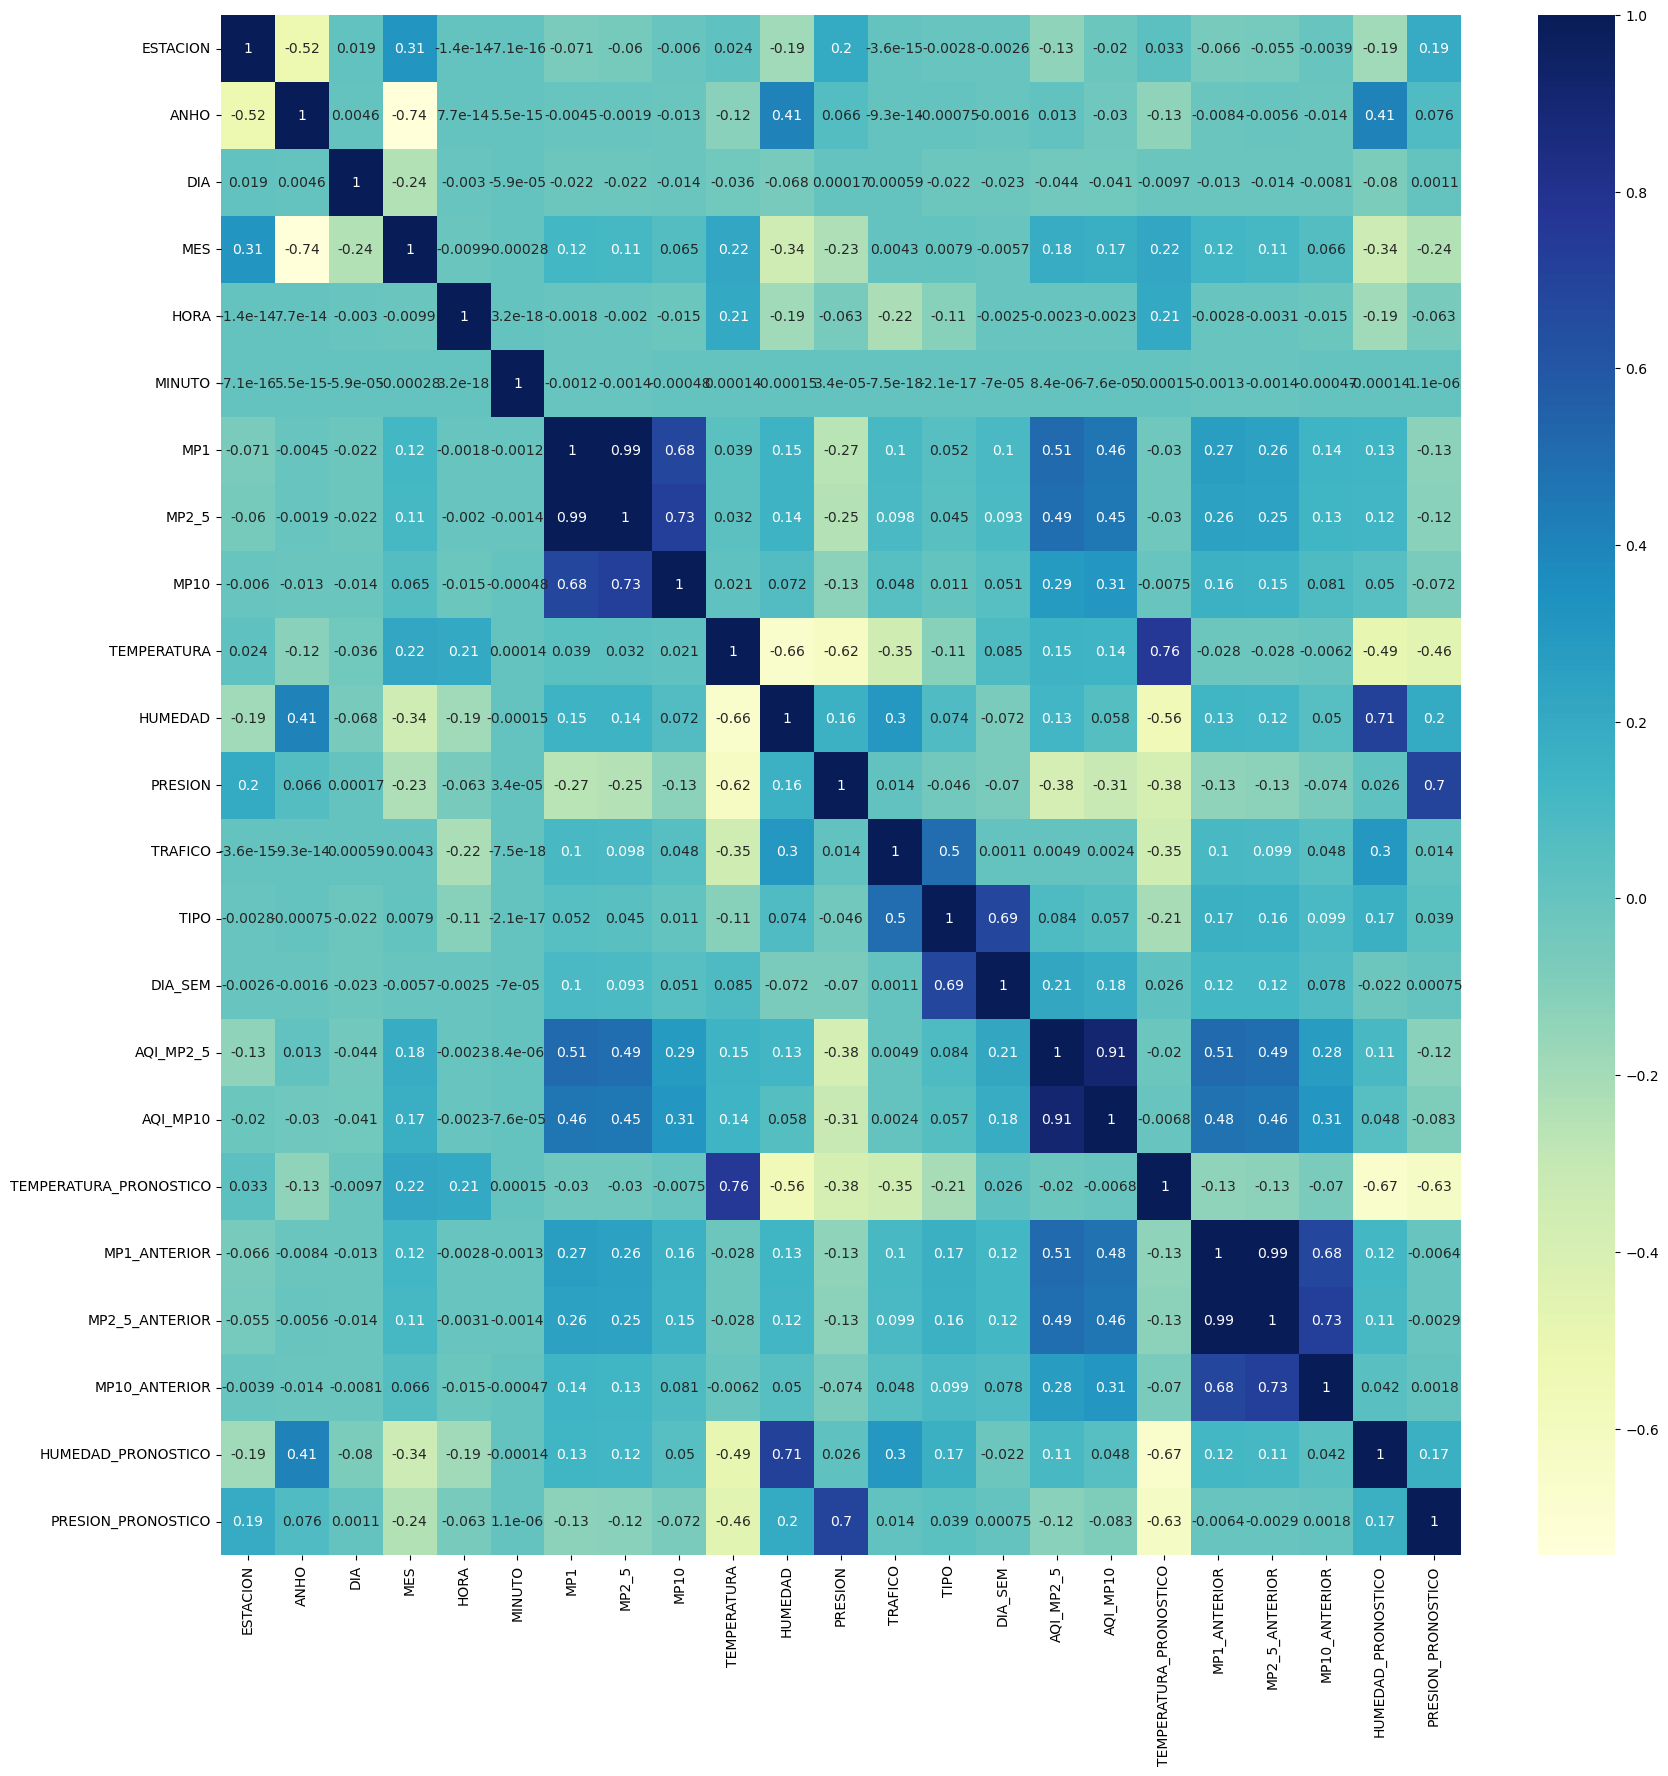

In [45]:
import matplotlib.pyplot as mp
print(df_heatmap.AQI_2_5.corr())

fig, ax = plt.subplots(figsize=(20,20)) 
# plotting correlation heatmap
dataplot = sn.heatmap(df_heatmap.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
mp.show()